In [1]:
import gpflow as gp
import tensorflow as tf
import tensorflow_probability as tfp
from bayes_tec.datapack import DataPack
import numpy as np

from bayes_tec.kernels import ThinLayer


def fit_thinlayer_kern(datapack, num_samples=100, burn=50, kern=gp.kernels.RBF, ant_sel=None, time_sel=None,dir_sel=None, pol_sel=slice(0,1,1), freq_sel=None,tec_scale=0.01):
    with DataPack(datapack,readonly=True) as datapack:
        datapack.select(time=time_sel, ant=ant_sel,pol=pol_sel, dir=dir_sel,freq=freq_sel)
        phase, axes = datapack.phase
        amp, axes = datapack.amplitude
        patch_names, directions = datapack.get_sources(axes['dir'])
        antenna_labels, antennas = datapack.get_antennas(axes['ant'])
        timestamps, times = datapack.get_times(axes['time'])
        _,freqs = datapack.get_freqs(axes['freq'])

    gains = amp*np.exp(1j*phase)
    g_mu = gains.mean(-2)
    phi = (np.angle(g_mu))
    tec_conv = -8.448e9/freqs
    dtec = phi[0,...]/np.mean(tec_conv)
    
    X = (times.mjd*86000. - times[0].mjd*86400.)
    X = X[:,None]
    Nd,Na,Nt = dtec.shape
    Y = dtec.transpose((2,0,1)).reshape((Nt,-1))/tec_scale
    
    with tf.Session(graph=tf.Graph()) as sess:
        with gp.defer_build():
            kern = kern(1)
            kern.lengthscales = 50.
            kern.lengthscales.transform = gp.transforms.positiveRescale(50.)
            kern.variance = 4.
            kern.variance.transform = gp.transforms.positiveRescale(1.)
            m = gp.models.GPR(X,Y,kern)
            m.likelihood.variance = 0.003**2/tec_scale**2
            m.likelihood.variance.trainable = False
            m.compile()
            gp.train.ScipyOptimizer().minimize(m)

            with tf.variable_scope('custom'):
                global_step = tf.Variable(0, trainable=False)
                starter_learning_rate = 1e-2
                end_learning_rate = 1e-5
                decay_steps = 1e4
                learning_rate = tf.train.polynomial_decay(starter_learning_rate,
                                                    global_step, decay_steps,
                                                    end_learning_rate, power=1.)

                opt = tfp.optimizer.StochasticGradientLangevinDynamics(learning_rate).minimize(m.objective,
                                                                                               var_list=m.trainable_tensors)
            init = tf.variables_initializer(tf.global_variables('custom'))
            out_t = [u.constrained_tensor for u in m.parameters]
            sess.run(init)
            p = []
            for i in range(num_samples):
                params, _ = sess.run([out_t, opt])
                p.append(params)
    p = np.array(p)
    p[:,1] = np.sqrt(p[:,1])*tec_scale
    p[:,2] = np.sqrt(p[:,2])*tec_scale
    
    return p[burn:,:]



/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __n

In [ ]:
import seaborn as sns
import pylab as plt
import pandas as pd
from bayes_tec.utils.data_utils import define_equal_subsets
import os

max_block_size, min_overlap = 200, 50
output_folder = './temporal_kernel_solve'
os.makedirs(output_folder,exist_ok=True)

with DataPack('../../scripts/data/killms_datapack_4.hdf5',readonly=True) as datapack:
    datapack.select(time=None, ant=None)
    axes = datapack.axes_phase
    patch_names, directions = datapack.get_sources(axes['dir'])
    antenna_labels, antennas = datapack.get_antennas(axes['ant'])
    timestamps, times = datapack.get_times(axes['time'])
    _,freqs = datapack.get_freqs(axes['freq'])
    
Nt = len(times)
solve_slices, _, _ = define_equal_subsets(Nt,max_block_size, min_overlap)
    
time_ = []
hpd_5 = np.zeros((62,3))
hpd_50 = np.zeros((62,3))
hpd_95 = np.zeros((62,3))
for i in range(1,62,1):
    ant = antenna_labels[i]
    for solve_slice in solve_slices:
        time_slice = slice(*solve_slice, 1)
        params = fit_temporal_kern('../../scripts/data/killms_datapack_4.hdf5', 200, 
                                   burn=50,kern=gp.kernels.Matern52, 
                                   ant_sel=slice(i,i+1,1), time_sel=time_slice,dir_sel=None, 
                                   pol_sel=slice(0,1,1), freq_sel=slice(0,48,1),tec_scale=0.01)

        df = pd.DataFrame(params[:,:],columns=['ls','sig','lik_sig'])
        sns.kdeplot(df['ls'],df['sig'],shade=True)
        plt.scatter(np.median(df['ls']),np.median(df['sig']),c='red')
        t = times[time_slice].mjd*86400.
        mean_time = int(np.mean(t))
        time_.append(mean_time)
        hpd_5[i,:] = np.array([np.percentile(p,5) for p in params.T])
        hpd_50[i,:] = np.array([np.percentile(p,50) for p in params.T])
        hpd_95[i,:] = np.array([np.percentile(p,95) for p in params.T])
        plt.title('Ant: {} | {}'.format(ant.astype(str),times[time_slice][t.size//2].isot))
        plt.savefig(os.path.join(output_folder,'{}_{}_matern52.png'.format(ant.astype(str), mean_time)))
        plt.close('all')
    np.savez(os.path.join(output_folder,'results_matern52.npz'),hpd_5=hpd_5, hpd_50 = hpd_50, hpd_95=hpd_95)

In [14]:
from bayes_tec.datapack import DataPack
import numpy as np
import pylab as plt

with DataPack('../../scripts/data/killms_datapack_4.hdf5',readonly=True) as datapack:
    datapack.select(time=slice(0,200,1), ant='RS210HBA',pol=slice(0,1,1), dir=None,freq=None)
    phase, axes = datapack.phase
    amp, axes = datapack.amplitude
    patch_names, directions = datapack.get_sources(axes['dir'])
    antenna_labels, antennas = datapack.get_antennas(axes['ant'])
    timestamps, times = datapack.get_times(axes['time'])
    _,freqs = datapack.get_freqs(axes['freq'])

gains = amp*np.exp(1j*phase)
g_mu = gains.mean(-2)
phi = np.unwrap(np.angle(g_mu),axis=-1)
tec_conv = -8.448e9/freqs
dtec = phi[0,...]/np.mean(tec_conv)

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


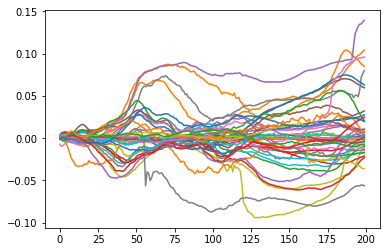

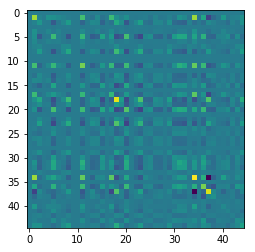

In [16]:
plt.plot(dtec[:,0,:].T)
plt.show()
plt.imshow(np.cov(dtec[:,0,:],rowvar=True))
plt.show()